# Clasificación de canciones con perceptrón multinivel
### Javier Andres Tellez Ortiz - 201617861

##### Se descarga el conjunto de datos y se descomprime

In [1]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [2]:
import wget
from zipfile import ZipFile

##Se descarga el archivo del repositorio 
file = wget.download("http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_genre_dataset.zip")

##Se abre el archivo y se descomprime
zpFile = ZipFile(file)
zpFile.extractall()
zpFile.close()

100% [........................................................................] 12656044 / 12656044

##### Se abre el conjunto de datos, se eliminan los datos con algún elemento faltante y se examina la estructura del mismo.

In [3]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("msd_genre_dataset.txt", skiprows = range(9))

dataset.dropna()
dataset.head()

,%genre,track_id,artist_name,title,loudness,tempo,time_signature,key,mode,duration,...,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
0,classic pop and rock,TRFCOOU128F427AEC0,Blue Oyster Cult,Mes Dames Sarat,-8.697,155.007,1,9,1,246.33424,...,1255.514569,580.030472,598.485223,575.337671,322.068603,321.726029,232.700609,186.805303,181.938688,151.508011
1,classic pop and rock,TRNJTPB128F427AE9F,Blue Oyster Cult,Screams,-10.659,148.462,1,4,0,189.80526,...,2007.653070,1043.474073,585.694981,564.013736,510.177022,400.200186,365.119588,238.099708,197.933757,251.577525
2,classic pop and rock,TRLFJHA128F427AEEA,Blue Oyster Cult,Dance The Night Away,-13.494,112.909,1,10,0,158.19710,...,1204.856777,2736.520024,730.233239,665.203452,535.775111,439.335059,486.822970,265.333860,447.097987,251.880724
3,classic pop and rock,TRCQZAG128F427DB97,Blue Oyster Cult,Debbie Denise,-12.786,117.429,4,7,1,250.22649,...,809.755802,563.908070,492.803819,378.382799,372.875044,231.941957,246.313305,168.400152,85.282462,339.897173
4,classic pop and rock,TRNXMNM128F427DB8C,Blue Oyster Cult,(Don't Fear) The Reaper,-14.093,141.536,4,9,0,307.06893,...,1093.684935,343.556047,889.163314,218.111796,304.862864,178.352161,440.478867,142.669283,81.061326,208.355152


##### Se obtienen los datos de las clases con los que se generará el modelo.  Previamente, se eliminaron las columnas 'track_id', 'artist_name' y 'title'

In [4]:
dataset = dataset.drop(columns = ["track_id", "artist_name", "title"])
features = dataset.columns.tolist()
dataset = dataset[(dataset["%genre"] == "jazz and blues") | (dataset["%genre"] == "soul and reggae")]

##### Se obtiene la cantidad total de datos pertenecientes a cada clase

In [5]:
pd.DataFrame(dataset["%genre"].value_counts())

,%genre
jazz and blues,4334
soul and reggae,4016


##### Se divide la información del archivo entre etiquetas y carácteristicas

In [9]:
y = dataset["%genre"].values
X = dataset.values[:,1:]

##### Cómo se evidencio en entregas anteriores, es necesaria la estándarizacion de los datos

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

##Se estandarizan los datos provenientes del archivo
X = scaler.fit(X).transform(X)

##### Se dividen los datos en datos de entrenamiento y datos de prueba, tomando el 20% del total para este último fin. Antes de realizar la división, los datos son barajados

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7861)

genres, cantidad = np.unique(y_test, return_counts = True)
total_test_data = sum(cantidad)
print("Datos de prueba clase %s: %d" % (genres[0],cantidad[0]))
print("Datos de prueba clase %s: %d" % (genres[1],cantidad[1]))
print("Total datos prueba: %d" % total_test_data)

Datos de prueba clase jazz and blues: 879
Datos de prueba clase soul and reggae: 791
Total datos prueba: 1670


##### Se toma el 10% de los datos de entrenamiento como datos de validación, esto con el objetivo de comparar cada uno de los modelos que serán entrenados

In [45]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.1, random_state = 7861)

genres, cantidad = np.unique(y_train, return_counts = True)
print("Datos de entrenamiento clase %s: %d" % (genres[0],cantidad[0]))
print("Datos de entrenamiento clase %s: %d" % (genres[1],cantidad[1]))

genres, cantidad = np.unique(y_validation, return_counts = True)
print("Datos de validacion clase %s: %d" % (genres[0],cantidad[0]))
print("Datos de validacion clase %s: %d" % (genres[1],cantidad[1]))

Datos de entrenamiento clase jazz and blues: 3915
Datos de entrenamiento clase soul and reggae: 3600
Datos de validacion clase jazz and blues: 419
Datos de validacion clase soul and reggae: 416


##### Se realiza el entrenamiento de las redes neuronales cambiando la cantidad de neuronas en la capa escondida entre 2 y el total de dimensiones del problema

In [84]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

dimensions = X.shape[1] + 1
models = []
models_log_loss = []

for neurons in range(2,dimensions):
    model = MLPClassifier(hidden_layer_sizes=(neurons),
                         batch_size=64,
                         max_iter=1000)
    
    neural_network = model.fit(X_train, y_train)
    probabilities = neural_network.predict_proba(X_validation)
    model_log_loss = log_loss(y_validation, probabilities)
    
    models_log_loss.append(model_log_loss)
    models.append(neural_network)
    
best_model_position = (models_log_loss.index(min(models_log_loss)))
best_model_neurons = best_model_position + 2
print("El modelo con mejor desempeño tiene %d neuronas en la capa oculta" % best_model_neurons)

best_model = models[best_model_position]

El modelo con mejor desempeño tiene 11 neuronas en la capa oculta


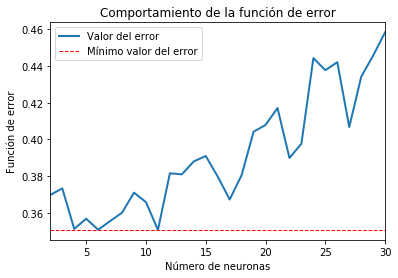

In [85]:
import pylab as pl
pl.plot(range(2,dimensions), 
        models_log_loss,
        linewidth=2,
        label='Valor del error')

pl.plot(range(2,dimensions),
        [models_log_loss[best_model_position]] * 29,
        linestyle = '--',
        linewidth = 1,
        color = 'red',
        label = 'Mínimo valor del error')

pl.xlim(2, 30)
pl.xlabel('Número de neuronas')
pl.ylabel('Función de error')
pl.title('Comportamiento de la función de error')
pl.legend()
pl.show()

##### Una vez obtenida la arquitectura con mejor rendimiento, se busca la función de activación que permite obtener mejores rendimientos

In [86]:
activations = ['relu','identity', 'logistic', 'tanh']
neurons = 11
models_activation_log_loss = []

for activation in activations:
    model = MLPClassifier(hidden_layer_sizes=(neurons),
                          batch_size=64,
                          max_iter=1000,
                          activation=activation)
        
    neural_network = model.fit(X_train, y_train)
    
    probabilities = neural_network.predict_proba(X_validation)
    model_log_loss = log_loss(y_validation, probabilities)
    
    models_activation_log_loss.append(model_log_loss)
    
best_activation_model_position = (models_activation_log_loss.index(min(models_activation_log_loss)))
best_activation = activations[best_activation_model_position]
print("El modelo con mejor rendimiento usó %s como función de activación" % best_activation)

El modelo con mejor rendimiento usó relu como función de activación


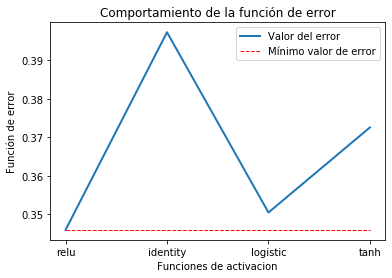

In [87]:
pl.plot(activations, 
        models_activation_log_loss,
        linewidth=2,
        label='Valor del error')

pl.plot(activations,
        [models_activation_log_loss[best_activation_model_position]] * 4,
        linestyle = '--',
        linewidth = 1,
        color = 'red',
        label = 'Mínimo valor de error')

pl.xlabel('Funciones de activacion')
pl.ylabel('Función de error')
pl.title('Comportamiento de la función de error')
pl.legend()
pl.show()

#### De acuerdo con los resultados anteriores, el modelo que mejor resultados tiene posee una capa escondida de 11 neuronas y emplea la función ReLU como función de activación. Se procede a probar diferentes algortimos de descenso de gradiente

In [91]:
algorithms = ['lbfgs', 'sgd', 'adam']
neurons = 11
activation = 'relu'
models_algorithms_log_loss = []

for algorithm in algorithms:
    model = MLPClassifier(hidden_layer_sizes=(neurons),
                          batch_size=64,
                          max_iter=2000,
                          activation=activation,
                          solver=algorithm)
        
    neural_network = model.fit(X_train, y_train)
    
    probabilities = neural_network.predict_proba(X_validation)
    model_log_loss = log_loss(y_validation, probabilities)
    
    models_algorithms_log_loss.append(model_log_loss)
    
best_algorithm_model_position = (models_algorithms_log_loss.index(min(models_algorithms_log_loss)))
best_algorithm = algorithms[best_algorithm_model_position]
print("El modelo con mejor rendimiento usó %s como algoritmo de entrenamiento" % best_algorithm)


El modelo con mejor rendimiento usó adam como algoritmo de entrenamiento


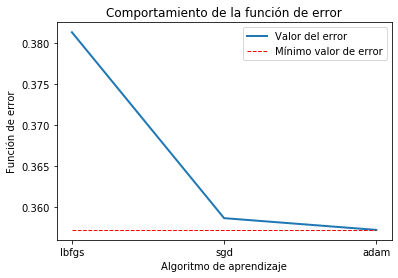

In [103]:
pl.plot(algorithms, 
        models_algorithms_log_loss,
        linewidth=2,
        label='Valor del error')

pl.plot(algorithms,
        [models_algorithms_log_loss[best_algorithm_model_position]] * 3,
        linestyle = '--',
        linewidth = 1,
        color = 'red',
        label = 'Mínimo valor de error')

pl.xlabel('Algoritmo de aprendizaje')
pl.ylabel('Función de error')
pl.title('Comportamiento de la función de error')
pl.legend()
pl.show()

In [98]:
learning_rates = [0.00001,0.00003,
                 0.0001, 0.0003,
                 0.001, 0.003,
                 0.01, 0.03,
                 0.1, 0.3,
                 1, 3]
algorithm = 'adam'
models_lr_log_loss = []

for learning_rate in learning_rates:
    model = MLPClassifier(hidden_layer_sizes=(neurons),
                          batch_size=64,
                          activation=activation,
                          solver=algorithm,
                          learning_rate_init=learning_rate,
                          max_iter=1000)
        
    neural_network = model.fit(X_train, y_train)
    
    probabilities = neural_network.predict_proba(X_validation)
    model_log_loss = log_loss(y_validation, probabilities)
    
    models_lr_log_loss.append(model_log_loss)
    
best_lr_model_position = (models_lr_log_loss.index(min(models_lr_log_loss)))
best_lr = learning_rates[best_lr_model_position]
print("El modelo con mejor rendimiento usó %f como tasa de aprendizaje" % best_lr)


El modelo con mejor rendimiento usó 0.000300 como tasa de aprendizaje


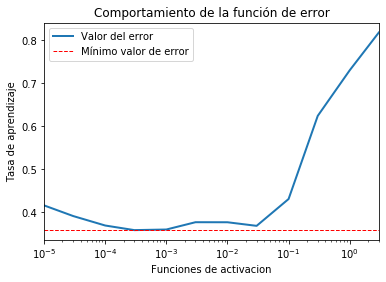

In [102]:
pl.semilogx(learning_rates, 
        models_lr_log_loss,
        linewidth=2,
        label='Valor del error')

pl.semilogx(learning_rates,
        [models_lr_log_loss[best_lr_model_position]] * 12,
        linestyle = '--',
        linewidth = 1,
        color = 'red',
        label = 'Mínimo valor de error')

pl.xlabel('Funciones de activacion')
pl.ylabel('Tasa de aprendizaje')
pl.title('Comportamiento de la función de error')
pl.legend()
pl.xlim(min(learning_rates), max(learning_rates))
pl.show()